In [ ]:
import json
# Standard libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import librosa
from google.colab import drive
import os

# Mount Google Drive for access
drive.mount('/content/drive')

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers


Mounted at /content/drive


In [ ]:
# Load data from JSON files training with MFCC and overlap
with open('/content/drive/MyDrive/My-207/X_train_mfcc.json', 'r') as file:
    X_train_list = json.load(file)
    X_train = np.array(X_train_list)

with open('/content/drive/MyDrive/My-207/y_train_mfcc.json', 'r') as file:
    y_train_list = json.load(file)
    y_train = np.array(y_train_list)

# Load data from JSON files
with open('/content/drive/MyDrive/My-207/X_val_mfcc.json', 'r') as file:
    X_val_list = json.load(file)
    X_val = np.array(X_val_list)

with open('/content/drive/MyDrive/My-207/y_val_mfcc.json', 'r') as file:
    y_val_list = json.load(file)
    y_val = np.array(y_val_list)

In [ ]:
# confirm that the data shape is same as before
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (7889, 20, 157)
y_train shape: (7889,)
X_val shape: (3121, 20, 157)
y_val shape: (3121,)


In [ ]:
# Data normalization
scaler = StandardScaler()
# Flatten X_train into a 2-dimensional array
X_train = X_train.reshape(X_train.shape[0], -1)
# Fit and transform the training data
X_train = scaler.fit_transform(X_train)

# Flatten X_val into a 2-dimensional array
X_val = X_val.reshape(X_val.shape[0], -1)
# Transform the validation data using the scaler parameters from the training data
X_val = scaler.transform(X_val)

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Save the label encoder for later use
label_encoder_path = "label_encoder.pkl"
import joblib
joblib.dump(label_encoder, label_encoder_path)

['label_encoder.pkl']

In [ ]:
# Build network topology
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])



In [ ]:
# Compile model
# Compile model with sparse categorical crossentropy loss
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3140)              0         
                                                                 
 dense (Dense)               (None, 512)               1608192   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [ ]:
# confirm that the data shape is same as before
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (7889, 3140)
y_train shape: (7889,)
X_val shape: (3121, 3140)
y_val shape: (3121,)


In [ ]:
from keras.callbacks import EarlyStopping

# Define the early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10)  # stop training after 3 epochs with no improvement

# Train the model with early stopping
history = model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), batch_size=32, epochs=100, callbacks=[early_stopping])


Epoch 1/100
247/247 [==============================] - 14s 59ms/step - loss: 0.7871 - accuracy: 0.8312 - val_loss: 1.2368 - val_accuracy: 0.6687
Epoch 2/100
247/247 [==============================] - 9s 35ms/step - loss: 0.7732 - accuracy: 0.8390 - val_loss: 1.3132 - val_accuracy: 0.6312
Epoch 3/100
247/247 [==============================] - 7s 27ms/step - loss: 0.7771 - accuracy: 0.8337 - val_loss: 1.2908 - val_accuracy: 0.6674
Epoch 4/100
247/247 [==============================] - 8s 33ms/step - loss: 0.7765 - accuracy: 0.8397 - val_loss: 1.2744 - val_accuracy: 0.6472
Epoch 5/100
247/247 [==============================] - 6s 26ms/step - loss: 0.7644 - accuracy: 0.8402 - val_loss: 1.4110 - val_accuracy: 0.6373
Epoch 6/100
247/247 [==============================] - 8s 33ms/step - loss: 0.7612 - accuracy: 0.8440 - val_loss: 1.3749 - val_accuracy: 0.6190
Epoch 7/100
247/247 [==============================] - 7s 27ms/step - loss: 0.7746 - accuracy: 0.8469 - val_loss: 1.2803 - val_accuracy

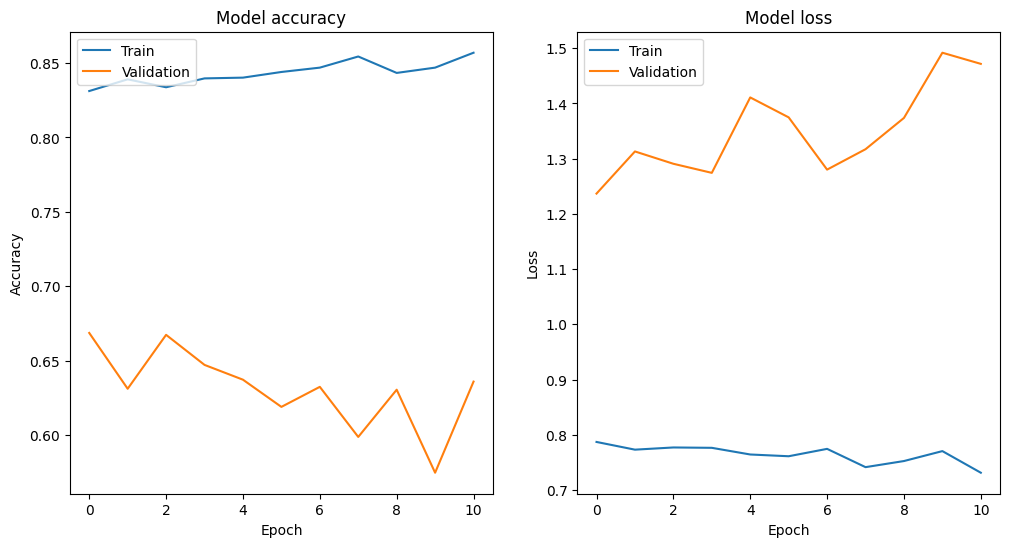

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
print(y_val_encoded.shape)


(3121,)


98/98 [==============================] - 1s 9ms/step


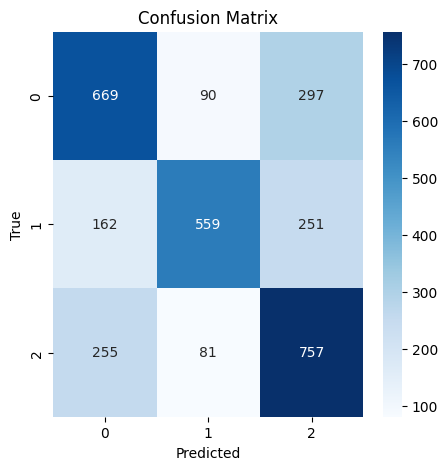

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_val_encoded  # No need for argmax

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)


# Plot the heatmap
plt.figure(figsize=(5,5))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/207/207-Project/notebooks/AA/FFNN_MFCC.h5')